## Load datasets

load the two CSV files:
- `original_preprocess.csv` (ORAN dataset)
- `dataset_ul.csv` (UL dataset)

also print their shapes to understand the dataset size.

In [1]:
import pandas as pd

oran = pd.read_csv("origin_data/original_preprocess.csv")
ul = pd.read_csv("origin_data/dataset_ul.csv")

In [2]:
print("ORAN raw shape:", oran.shape)
print("UL raw shape  :", ul.shape)

ORAN raw shape: (17501, 39)
UL raw shape  : (20018, 40)


In [3]:
oran.head()
oran.shape
oran.columns

Index(['date', 'BW', 'TM', 'traffic_load_dl', 'traffic_load_ul', 'txgain_dl',
       'txgain_ul', 'selected_mcs_dl', 'selected_mcs_ul',
       'selected_airtime_dl', 'selected_airtime_ul', 'mean_used_mcs_dl',
       'mean_used_mcs_ul', 'bsr_dl', 'bsr_ul', 'gput_ul', 'mean_snr_ul',
       'turbodec_it', 'dec_time', 'nRBs_ul', 'num_ues', 'thr_dl', 'thr_ul',
       'bler_dl', 'bler_ul', 'tbs_dl', 'pm_power', 'pm_var', 'pm_median',
       'n_pm', 'rapl_power', 'rapl_var', 'n_rapl', 'clockspeed', 'airtime_dl',
       'airtime_ul', 'cqi_dl', 'cqi_ul', 'fixed_mcs_flag'],
      dtype='object')

In [4]:
oran.isna().sum()
oran = oran.dropna()
oran = oran[oran["pm_power"] > 0]

In [9]:
ul.shape
ul.columns

Index(['date', 'cpu_platform', 'BW', 'TM', 'UL/DL', 'traffic_load', 'txgain',
       'cpu_time', 'number_active_cores', 'pinning', 'cpu_config',
       'selected_mcs', 'selected_airtime', 'mean_used_mcs', 'bsr', 'num_ues',
       'thr', 'gput', 'mean_snr', 'var_snr', 'bler', 'turbodec_it',
       'rssi_mean', 'rssi_var', 'overflows', 'underflows', 'lates', 'dec_time',
       'pm_power', 'pm_var', 'n_pm', 'rapl_power', 'rapl_var', 'n_rapl',
       'clockspeed', 'nRBs', 'airtime', 'num_subsamples', 'fixed_mcs_flag',
       'failed_experiment'],
      dtype='object')

In [5]:
ul.isna().sum()
ul = ul.dropna()
ul = ul[ul["rapl_power"] > 0]

## Define target and common features

To enable fair comparison and transfer learning, choosing a small set of robust common features that exist in both datasets, which can be mapped easily.

Target variable:
- predict **pm_power** (power meter measurement).  

Selected common features (input X):
- airtime
- selected_mcs
- mean_used_mcs
- mean_snr


This results in a compact aligned dataset with 5 input features and 1 target column.


In [6]:
TARGET = "pm_power"

COMMON_FEATURES = [
    "airtime",
    "selected_mcs",
    "mean_used_mcs",
    "mean_snr",

]


## ORAN preprocessing and alignment

The ORAN dataset contains separate UL/DL columns (e.g., `airtime_ul`, `traffic_load_ul`).
Since this project focuses on uplink behaviour, extract the UL-related columns and rename them into a shared naming scheme.

Steps:
1) Select the relevant UL columns and the target column.
2) Rename the UL columns (e.g., `airtime_ul` → `airtime`) to match the UL dataset.
3) Convert all selected columns to numeric format.
4) Remove rows with missing values and invalid target values (power ≤ 0).

The output is a cleaned ORAN table with the same column names as the UL table.


In [7]:

oran_colmap = {
    "airtime_ul": "airtime",
    "selected_mcs_ul": "selected_mcs",
    "mean_used_mcs_ul": "mean_used_mcs",
    "mean_snr_ul": "mean_snr",

    TARGET: TARGET  
}

oran_needed_cols = list(oran_colmap.keys())


oran = oran[oran_needed_cols].copy()
oran = oran.rename(columns=oran_colmap)

for c in COMMON_FEATURES + [TARGET]:
    oran[c] = pd.to_numeric(oran[c], errors="coerce")

oran = oran.dropna(subset=COMMON_FEATURES + [TARGET])
oran = oran[oran[TARGET] > 0]

print("✅ ORAN cleaned shape:", oran.shape)

✅ ORAN cleaned shape: (17501, 5)


## UL preprocessing

The UL dataset only contains ULrecords, and may include failed experiments.

Steps:
1) Filter to keep **UL** records only (`UL/DL == "UL"`).
2) Remove failed experiments (`failed_experiment == 0`).
3) Keep only the selected common features and the target column.
4) Convert selected columns to numeric format.
5) Remove missing values and invalid target values (power ≤ 0).

The output is a cleaned UL table with the same columns as the ORAN table.


In [8]:
ul = ul.copy()

if "UL/DL" in ul.columns:
    ul = ul[ul["UL/DL"] == "UL"]

if "failed_experiment" in ul.columns:
    ul = ul[ul["failed_experiment"] == 0]

needed_ul_cols = COMMON_FEATURES + [TARGET]
ul = ul[needed_ul_cols].copy()

for c in COMMON_FEATURES + [TARGET]:
    ul[c] = pd.to_numeric(ul[c], errors="coerce")

ul = ul.dropna(subset=COMMON_FEATURES + [TARGET])
ul = ul[ul[TARGET] > 0]

print("✅ UL cleaned shape:", ul.shape)

✅ UL cleaned shape: (18909, 5)


## Alignment check and Export cleaned datasets

To ensure the two datasets can be used in baseline comparison and transfer learning, verify that:
- Both datasets contain exactly the same column set
- The column order is identical

This confirms that the input feature space is aligned.

And also save the cleaned aligned datasets as new CSV files

In [9]:
print("ORAN columns:", oran.columns.tolist())
print("UL columns  :", ul.columns.tolist())

assert oran.columns.tolist() == ul.columns.tolist(), "❌ Column mismatch after preprocessing!"
print("✅ Column alignment confirmed.")

oran.to_csv("clean_oran_stage1.csv", index=False)
ul.to_csv("clean_ul_stage1.csv", index=False)

print("🎉 Saved: clean_oran_stage1.csv and clean_ul_stage1.csv")

ORAN columns: ['airtime', 'selected_mcs', 'mean_used_mcs', 'mean_snr', 'pm_power']
UL columns  : ['airtime', 'selected_mcs', 'mean_used_mcs', 'mean_snr', 'pm_power']
✅ Column alignment confirmed.
🎉 Saved: clean_oran_stage1.csv and clean_ul_stage1.csv


## Visualisation: Power distribution (UL)

Plot the histogram of the target power variable to understand:
- Typical power range
- Whether the distribution is unimodal or multi-modal
- Whether there are abnormal values

A multi-modal distribution can indicate multiple operating regimes (e.g., different system configurations).


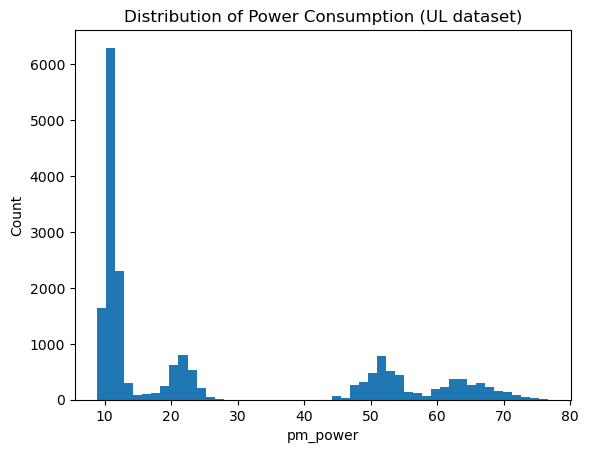

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(ul[TARGET], bins=50)
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.title("Distribution of Power Consumption (UL dataset)")
plt.show()


##  Visualisation: Power vs Airtime (UL)

Plot a scatter plot between airtime and power to check whether:
- There is an observable trend
- The relationship appears linear or non-linear
- Multiple power levels exist for the same airtime value 

This supports the motivation for using machine learning rather than simple linear rules.

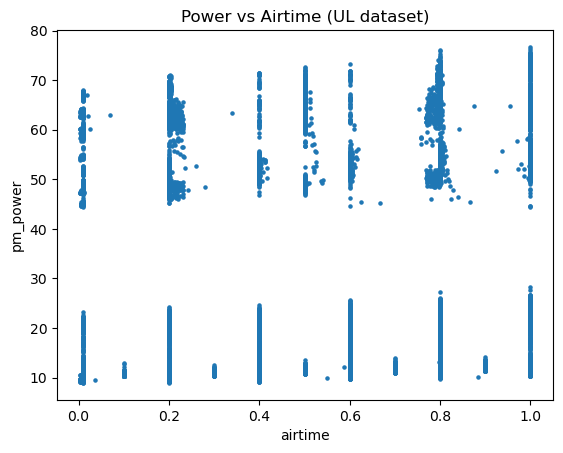

In [11]:
plt.figure()
plt.scatter(ul["airtime"], ul[TARGET], s=5)
plt.xlabel("airtime")
plt.ylabel(TARGET)
plt.title("Power vs Airtime (UL dataset)")
plt.show()


## Visualisation: ORAN vs UL power distribution comparison

Compare the target power distributions across ORAN and UL datasets.
If the distributions differ, this indicates a dataset shift between data sources.

A clear distribution shift motivates transfer learning:
- The task is the same (predict power)
- Feature semantics are aligned
- But the data distributions differ across domains


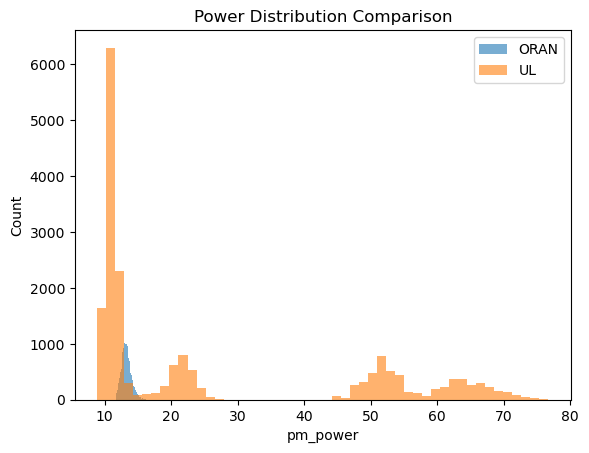

In [12]:
plt.figure()
plt.hist(oran[TARGET], bins=50, alpha=0.6, label="ORAN")
plt.hist(ul[TARGET], bins=50, alpha=0.6, label="UL")
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.legend()
plt.title("Power Distribution Comparison")
plt.show()


## Summary 

In Stage 1, cleaned and aligned two independent datasets into a shared feature space consisting of a small set of common features and one power target variable. 

Basic visualisations show:
- The target power distribution in UL is multi-modal, suggesting different operating regimes.
- The relationship between airtime and power is not purely linear.
- ORAN and UL have different power distributions, indicating a distribution shift.

These observations motivate the use of machine learning and transfer learning in the next stages.